In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
%matplotlib inline
import imageio
from PIL import Image, ImageEnhance
import os
import matplotlib.ticker as ticker
import seaborn as sns

It is a notebook, where biofilm images at different phases were chosen to demonstrate biofilm growth

In [2]:
def augment_pic(orig_path, path=None, contrast=3, light_coef=0.1):
    im = Image.open(orig_path)
    print(im)
    enhancer = ImageEnhance.Contrast(im)
    im_output = enhancer.enhance(contrast)
    out = np.array(im_output)
    dark_img = light_coef*out
    img = dark_img.astype('uint8')
    plt.imshow(img, cmap='gray')
    
    if path:
        imageio.imwrite(path, img)
        
    plt.show()
    

In [3]:
with open('/home/kskozlov/files_for_research/bacteria_img_analysis/phases_results.pkl', 'rb') as f:
    preds = pkl.load(f)

In [5]:
colors_dict = {
    'bacteria' : (251, 186, 14),
    'matrix': (64, 105, 42),
    'channel': (55, 94, 152),
    'cells-free zone': (236, 102, 70)}

In [6]:
def get_mask_tensor(pred):
    mask_tensor = pred[0].argmax(axis=0)
    masked_image = np.zeros(shape=(mask_tensor.shape[0], mask_tensor.shape[1], 3))
    for i, layer in enumerate(list(colors_dict.keys())):
            masked_image[:,:][mask_tensor == i] = colors_dict[layer]
            
    return masked_image.astype('uint8'), mask_tensor

In [12]:
orig_path = f'../data/biofilm_formation_images/'

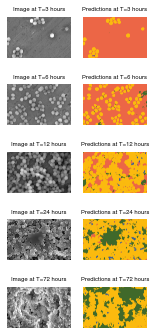

In [13]:
results={
    0: [],
    1: [],
    2: [],
    3: []
}

t = [3, 6, 12, 24, 72]
plt.rcParams['font.family'] = 'Nimbus Sans'
plt.rcParams.update({'font.size': 5})
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(2.5, 6))
for j, pred in enumerate(preds):
    masked_image, mask_tensor = get_mask_tensor(pred)
    labels, values = np.unique(mask_tensor, return_counts=True)
    values_proc = values/sum(values)*100
    prev = -0.5
    for i, label in enumerate(labels):
        results[label].append(values_proc[i])
        if (label - prev) > 1:
            results[prev+1].append(0)
        prev = label 
        
    image = cv2.imread(orig_path + f'{j+1}.tif')
    ax[j, 0].set_title(f'Image at T={t[j]} hours')
    ax[j, 0].imshow(image[:masked_image.shape[0], :, :])
    ax[j, 0].axis('off')
    
    ax[j, 1].set_title(f'Predictions at T={t[j]} hours')
    ax[j, 1].imshow(masked_image)
    ax[j, 1].axis('off')

#plt.savefig('phases-examples-model-preds-SI.png', dpi=300, bbox_inches='tight')
plt.show()

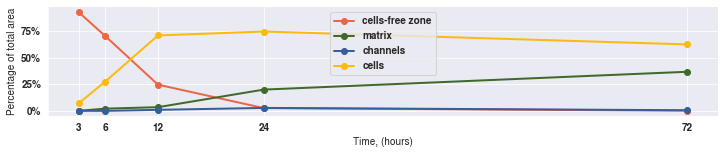

In [14]:
time = [3, 6, 12, 24, 72]

sns.set_style("darkgrid")
plt.rcParams['font.family'] = 'Nimbus Sans'
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'font.weight': 'bold'})

colors=['#FBBA0E', '#40692A', '#375E98', '#EC6646']
legend_names = ['cells', 'matrix', 'channels', 'cells-free zone']
fig, ax = plt.subplots(figsize=(12, 2))
ax.set_xticks([3, 6, 12, 24, 72])
for i in [3, 1, 2, 0]:
    y2=results[i]
    ax.plot(time, y2, c=colors[i], marker='o', linewidth=2, label=legend_names[i])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
ax.set_xlabel('Time, (hours)')
ax.set_ylabel('Percentage of total area')
ax.legend()
#plt.savefig('biofilm_development_dynamics.png', dpi=300, bbox_inches="tight")
plt.show()